In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import plotly.graph_objects as go
import fasttext
import fasttext.util
from kneed import KneeLocator
import plotly.io as pio
import os

# Set the working directory to the previous directory
os.chdir('..')

In [2]:
""" To load it from gdrive if you have it there and wanna use colab
from google.colab import drive
drive.mount('/content/drive')

!gunzip /content/drive/MyDrive/cc.en.300.bin.gz
model_path = '/content/drive/MyDrive/cc.en.300.bin'
ft = fasttext.load_model(model_path)
"""

" To load it from gdrive if you have it there and wanna use colab\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n!gunzip /content/drive/MyDrive/cc.en.300.bin.gz\nmodel_path = '/content/drive/MyDrive/cc.en.300.bin'\nft = fasttext.load_model(model_path)\n"

In [2]:
# Download the pre-trained FastText model [default option]
#fasttext.util.download_model('en', if_exists='ignore', model_dir=./models/)  # Specify language code ('en' for English)

# Load the downloaded model
ft = fasttext.load_model('./models/fasttext/cc.en.300.bin')

In [3]:
df = pd.read_csv("./data/lyrics_proc_train.csv")
print('Data rows number: ', len(df))
df.head()

Data rows number:  4736


,id,artist,title,lyrics,lyrics_proc
0,7828,Bon Jovi,Let It Rock,\n\r\nThe weekend comes to this town \r\nSeven...,weekend come town seven soon make break rule w...
1,2706,Eminem,Music Box,"\n\r\nYeah, girl.\nCan you hear that?\nIt's pl...",girl hear play song sleepi take afraid dark he...
2,4658,Johnny Cash,Redemption Day,\n\r\nI've wept for those who suffer long\r\nB...,wept suffer long weep gone room grief question...
3,14321,Beyonce,Party (Homecoming Live),"\n\r\nI may be young, but I'm ready\nTo give y...",young readi give love told girl slow love give...
4,4352,Johnny Cash,I Came To Believe,\n\r\nI couldn't manage the problems I laid on...,could manag problem laid made wors laid somebo...


In [4]:
def embed_lyrics_batch(lyrics_batch, model):
    embeddings = []
    for text in lyrics_batch:
        embedding = model.get_sentence_vector(text)
        embeddings.append(embedding)
    return np.array(embeddings)

# get the lyrics
lyrics_list = df['lyrics_proc'].tolist()

batch_size = 1000 # have to do it in batches or it exceeds the resources available on colab
all_embeddings = []

for i in range(0, len(lyrics_list), batch_size):
    lyrics_batch = lyrics_list[i:i+batch_size]
    batch_embeddings = embed_lyrics_batch(lyrics_batch, ft)
    all_embeddings.extend(batch_embeddings)

# Convert the list of embeddings to a single array
embeddings_array = np.array(all_embeddings)

print(embeddings_array[:10])
print(f"Embeddings Array Shape: {embeddings_array.shape}")


[[ 0.00440831 -0.00209347  0.00887711 ...  0.08569305  0.0062998
  -0.0345219 ]
 [-0.00171202  0.00429279  0.01518531 ...  0.05807457  0.00411541
  -0.02312498]
 [ 0.00727055  0.00792266  0.00781353 ...  0.06341165  0.00846662
  -0.00868934]
 ...
 [-0.01682455 -0.01525836  0.00076513 ...  0.07164253  0.01333271
  -0.0018794 ]
 [-0.01422214  0.01838822  0.00984802 ...  0.06501947 -0.00198321
  -0.013449  ]
 [-0.00272016  0.02642392  0.01670563 ...  0.0538277  -0.01265352
  -0.00242214]]
Embeddings Array Shape: (4736, 300)


In [5]:
# Add embeddings to the original DataFrame as a single column
df['fastText_embeddings'] = embeddings_array.tolist()
df.head()

,id,artist,title,lyrics,lyrics_proc,fastText_embeddings
0,7828,Bon Jovi,Let It Rock,\n\r\nThe weekend comes to this town \r\nSeven...,weekend come town seven soon make break rule w...,"[0.004408314358443022, -0.002093471586704254, ..."
1,2706,Eminem,Music Box,"\n\r\nYeah, girl.\nCan you hear that?\nIt's pl...",girl hear play song sleepi take afraid dark he...,"[-0.0017120193224400282, 0.004292791243642569,..."
2,4658,Johnny Cash,Redemption Day,\n\r\nI've wept for those who suffer long\r\nB...,wept suffer long weep gone room grief question...,"[0.007270548027008772, 0.007922656834125519, 0..."
3,14321,Beyonce,Party (Homecoming Live),"\n\r\nI may be young, but I'm ready\nTo give y...",young readi give love told girl slow love give...,"[-0.0006487257196567953, -0.01772562973201275,..."
4,4352,Johnny Cash,I Came To Believe,\n\r\nI couldn't manage the problems I laid on...,could manag problem laid made wors laid somebo...,"[-0.019676899537444115, 0.007487020920962095, ..."


In [6]:
def find_optimal_pca_dimensions(df, embeddings_column, dimensions, n_clusters=5):

    # Extract the embeddings from the DataFrame
    embeddings = np.stack(df[embeddings_column].values)

    # Apply Standard Scaler
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)

    results = []
    for dim in dimensions:
        # Apply PCA
        pca = PCA(n_components=dim)
        reduced_embeddings = pca.fit_transform(scaled_embeddings)

        # Cluster the reduced embeddings
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(reduced_embeddings)

        # Compute the Silhouette score
        silhouette_avg = silhouette_score(reduced_embeddings, cluster_labels)

        # Calculate variance preserved
        variance_preserved = np.sum(pca.explained_variance_ratio_)

        # Append results
        results.append({
            'Dimensions': dim,
            'Silhouette Score': silhouette_avg,
            'Variance Preserved': variance_preserved
        })

    return pd.DataFrame(results)

dimensions = [2,3,5,10,15,20,35,50]

table = find_optimal_pca_dimensions(df,'fastText_embeddings',dimensions)
table


,Dimensions,Silhouette Score,Variance Preserved
0,2,0.336521,0.163057
1,3,0.256168,0.211397
2,5,0.181519,0.270882
3,10,0.122527,0.373098
4,15,0.100258,0.445126
5,20,0.087973,0.498790
6,35,0.071210,0.607862
7,50,0.062191,0.682424


In [7]:
def find_best_tradeoff(results_df):

    # Calculate the absolute difference between the normalized metrics
    results_df['Difference'] = np.abs(results_df['Silhouette Score'] - results_df['Variance Preserved'])

    # Find the dimension with the minimum difference
    best_dimension = results_df.loc[results_df['Difference'].idxmin(), 'Dimensions']

    return best_dimension, results_df

best_dim, _ = find_best_tradeoff(table)
print("The best dimension is: ", best_dim)

# Extract the embeddings from the DataFrame
embeddings = np.stack(df['fastText_embeddings'].values)

# Apply Standard Scaler
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

# Apply PCA
pca = PCA(n_components=best_dim)
reduced_embeddings = pca.fit_transform(scaled_embeddings)

# Add reduced embedding as new column
df['reduced_embeddings'] = reduced_embeddings.tolist()
df.head()

The best dimension is:  3


,id,artist,title,lyrics,lyrics_proc,fastText_embeddings,reduced_embeddings
0,7828,Bon Jovi,Let It Rock,\n\r\nThe weekend comes to this town \r\nSeven...,weekend come town seven soon make break rule w...,"[0.004408314358443022, -0.002093471586704254, ...","[3.4143864426503527, 1.4965541571885281, -4.52..."
1,2706,Eminem,Music Box,"\n\r\nYeah, girl.\nCan you hear that?\nIt's pl...",girl hear play song sleepi take afraid dark he...,"[-0.0017120193224400282, 0.004292791243642569,...","[4.631233592496089, 2.05837152516666, -0.73589..."
2,4658,Johnny Cash,Redemption Day,\n\r\nI've wept for those who suffer long\r\nB...,wept suffer long weep gone room grief question...,"[0.007270548027008772, 0.007922656834125519, 0...","[2.451412499888947, 4.633851373494001, -0.9008..."
3,14321,Beyonce,Party (Homecoming Live),"\n\r\nI may be young, but I'm ready\nTo give y...",young readi give love told girl slow love give...,"[-0.0006487257196567953, -0.01772562973201275,...","[0.949947184468595, -4.028308899201592, 3.7322..."
4,4352,Johnny Cash,I Came To Believe,\n\r\nI couldn't manage the problems I laid on...,could manag problem laid made wors laid somebo...,"[-0.019676899537444115, 0.007487020920962095, ...","[-3.134579176559024, 3.4868104767613723, -0.50..."


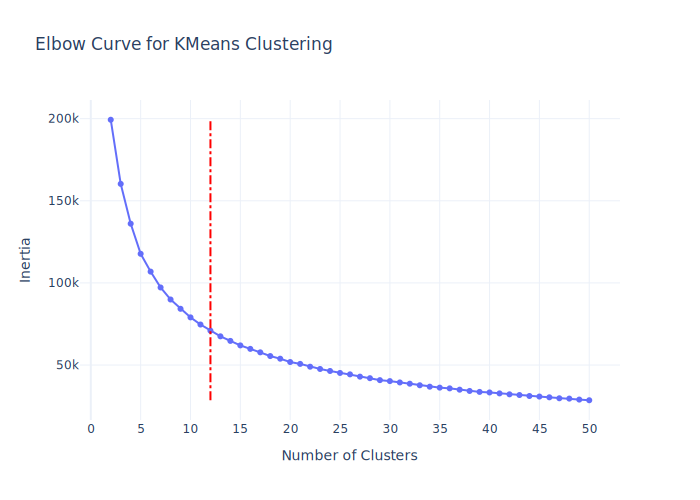

The best number of clusters is:  12


In [9]:
def plot_elbow_curve(df, cluster_range=(2, 50)):
    # Extract the embeddings from the DataFrame
    reduced_embeddings = np.stack(df['reduced_embeddings'].values)

    # Initialize variables to store inertia values
    cluster_range_values = range(cluster_range[0], cluster_range[1] + 1)
    inertia_values = []

    # Compute inertia for each number of clusters
    for n_clusters in cluster_range_values:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(reduced_embeddings)
        inertia_values.append(kmeans.inertia_)

    # Use the KneeLocator to find the elbow point
    knee = KneeLocator(cluster_range_values, inertia_values, curve='convex', direction='decreasing')

    # Plot the elbow curve using Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=list(cluster_range_values)[::1],
        y=inertia_values,
        mode='lines+markers',
        name='Inertia'
    ))

    fig.add_shape(
        type="line",
        x0=knee.elbow,
        y0=min(inertia_values),
        x1=knee.elbow,
        y1=max(inertia_values),
        line=dict(
            color="red",
            width=2,
            dash="dashdot",
        ),
    )

    fig.update_layout(
        title='Elbow Curve for KMeans Clustering',
        xaxis_title='Number of Clusters',
        yaxis_title='Inertia',
        xaxis=dict(tickmode='linear', dtick=5),
        template='plotly_white'
    )

    # Save plot
    pio.write_image(fig, './plots/fasttex_elbow.pdf')
    # Show the plot
    fig.show("svg")
    return knee.elbow
    
n_clusters = plot_elbow_curve(df)
print("The best number of clusters is: ", n_clusters)

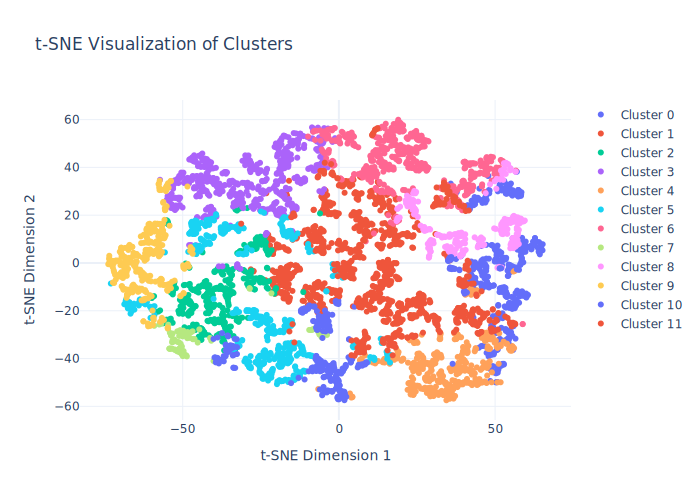

In [10]:
def perform_clustering_and_visualize(df,n_clusters):
    # Extract the embeddings from the DataFrame
    reduced_embeddings = np.stack(df['reduced_embeddings'].values)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_embeddings)

    # Apply t-SNE for visualization
    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(reduced_embeddings)

    # Create a DataFrame for visualization
    tsne_df = pd.DataFrame(tsne_embeddings, columns=['x', 'y'])
    tsne_df['cluster'] = cluster_labels

    # Create a plotly scatter plot
    fig = go.Figure()

    # Add traces for each cluster
    for cluster in range(n_clusters):
        cluster_df = tsne_df[tsne_df['cluster'] == cluster]
        fig.add_trace(go.Scatter(
            x=cluster_df['x'], y=cluster_df['y'],
            mode='markers',
            name=f'Cluster {cluster}',
            marker=dict(size=6),
            #text=cluster_df.index
        ))

    # Update layout
    fig.update_layout(
        title='t-SNE Visualization of Clusters',
        xaxis_title='t-SNE Dimension 1',
        yaxis_title='t-SNE Dimension 2',
        template='plotly_white',
        showlegend=True
    )

    # Save plot
    pio.write_image(fig, './plots/fasttext_tsne.pdf')
    # Show plot
    fig.show("svg")

    return cluster_labels

cluster_labels = perform_clustering_and_visualize(df, n_clusters)
# Add cluster labels to the lyrics embeddings
df['cluster'] = cluster_labels

In [11]:
def top_n_similar_embeddings(df, target_index, n=10):

    # Extract the target embedding and its cluster
    target_embedding = df.at[target_index, 'reduced_embeddings']
    target_cluster = df.at[target_index, 'cluster']

    # Filter the DataFrame to get only the embeddings in the same cluster
    cluster_df = df[df['cluster'] == target_cluster]
    cluster_embeddings = np.stack(cluster_df['reduced_embeddings'].values)

    # Calculate cosine similarities
    similarities = cosine_similarity([target_embedding], cluster_embeddings)[0]

    # Get the top n similar embeddings
    top_n_indices = np.argsort(similarities)[-n-1:][::-1]
    top_n_similar_ids = cluster_df.iloc[top_n_indices]['id'].values
    top_n_similarities = similarities[top_n_indices]

    return pd.DataFrame({
        'id': top_n_similar_ids,
        'similarity': top_n_similarities
    })

# Show top 10 similar song to the first song (the first row is the song itself)
top_n_similar_embeddings(df,target_index=0,n=10)

,id,similarity
0,7828,1.000000
1,22982,0.999728
2,21293,0.997713
3,9891,0.996066
4,9588,0.995048
5,16603,0.994447
6,15855,0.993960
7,13235,0.993226
8,11736,0.991875
9,9198,0.991441
